## Crop/select aera and calculate cloud fraction should be done in the same period.

In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [7]:
path = '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/'
add = "archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/"

In [8]:
#path = '/home/hanna/Desktop/master_thesis/meteosat0/'

In [9]:
files = glob.glob(path+add+"*.grb")

In [10]:
files

['/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/MSG2-SEVI-MSGCLMK-0100-0100-20090101000000.000000000Z-20090101001246-1336736.grb',
 '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/MSG2-SEVI-MSGCLMK-0100-0100-20090101060000.000000000Z-20090101061254-1336736.grb',
 '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/MSG2-SEVI-MSGCLMK-0100-0100-20090101120000.000000000Z-20090101121252-1336736.grb',
 '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/MSG2-SEVI-MSGCLMK-0100-0100-20090101180000.000000000Z-20090101181252-1336736.grb',
 '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/MSG2-SEVI-MSGCLMK-0100-0100-

In [11]:
first_file = files[0]

In [12]:
def timestamp(filename):
    """
    Returns the np.datetime64 [ns] for the current date.
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:-1]
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

In [13]:
def merge_ts():
    pass

In [27]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)

    # TODO :: dimensions with coordinates
    #data = data.assign_coords(latitude = np.arange(-67.5, 67.5, 3712))
    #data = data.assign_coords(longitude = np.arange(-67.5, 67.5, 3712))    
    
    #data['xgrid_0'] = np.linspace(-67.5, 67.5, 3712)
    #data['ygrid_0'] = np.linspace(-67.5, 67.5, 3712)

    
    data = data.expand_dims(dim = 'time' )
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={#'xgrid_0': 'longitude', 
                                  #'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # TODO :: import region
    #data = data.sel(latitude = slice(30,60))
    #data = data.sel(longitude = slice(-15, 42))

    # Check that it contains no 4's
    nr_4 = (data.tcc == 3.0).sum().values
    if nr_4 > 0:
        print( nr_4 )
    else:
        print("We are all good.")
        
    # Replace values --> final result cloud = 1, no_cloud = 0.
    # currently not replacing any values.
    data = data.where(data.tcc - 1 < 0.0001, 0)
        
    return data

In [28]:
np.linspace(-67.5, 67.5, 3712)

array([-67.5       , -67.46362167, -67.42724333, ...,  67.42724333,
        67.46362167,  67.5       ])

In [29]:

#np.sqrt(13778944)

In [30]:
dset = fix_one_sat_file(first_file)
dset1 = fix_one_sat_file(files[1])

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.


4354580
4354580


In [31]:
dset

<xarray.Dataset>
Dimensions:  (time: 1, xgrid_0: 3712, ygrid_0: 3712)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01
Dimensions without coordinates: xgrid_0, ygrid_0
Data variables:
    tcc      (time, ygrid_0, xgrid_0) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [32]:
dset.merge(dset1)

<xarray.Dataset>
Dimensions:  (time: 2, xgrid_0: 3712, ygrid_0: 3712)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 2009-01-01T06:00:00
Dimensions without coordinates: xgrid_0, ygrid_0
Data variables:
    tcc      (time, ygrid_0, xgrid_0) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [33]:
#(dset.tcc == 3.0).sum().values

In [57]:
seviri_0deg =  {

    'description': 'Full globe MSG image 0 degrees',
    'projection': {    'proj': 'geos', 'lon_0': 0.0, 'a': 6378169.0, 'b': 6356583.8, 'h': 35785831.0}, 
    'shape':{ 'height': 3712,  'width': 3712},
    'area_extent':{ 'lower_left_xy': [-5570248.686685662, -5567248.28340708],
                    'upper_right_xy': [5567248.28340708, 5570248.686685662]}

}

In [64]:
proj_dict = seviri_0deg['projection']

In [70]:
proj_dict

{'a': 6378169.0, 'b': 6356583.8, 'h': 35785831.0, 'lon_0': 0.0, 'proj': 'geos'}

In [82]:
def get_geostationary_angle_extent(proj_dict):
    """Get the max earth (vs space) viewing angles in x and y."""
    # TODO: take into account sweep_axis_angle parameter

    # get some projection parameters
    req = proj_dict['a'] / 1000
    rp = proj_dict['b'] / 1000
    h = proj_dict['h'] / 1000 + req

    # compute some constants
    aeq = 1 - req**2 / (h ** 2)
    ap_ = 1 - rp**2 / (h ** 2)

    # generate points around the north hemisphere in satellite projection
    # make it a bit smaller so that we stay inside the valid area
    xmax = np.arccos(np.sqrt(aeq))
    ymax = np.arccos(np.sqrt(ap_))
    return xmax, ymax

In [104]:
get_geostationary_angle_extent(proj_dict=proj_dict)

(0.15185342867090912, 0.15133555510297725)

In [110]:

def get_geostationary_bounding_box(proj_dict, nb_points=50):
    """Get the bbox in lon/lats of the valid pixels inside *geos_area*.
    Args:
      nb_points: Number of points on the polygon
    """
    xmax, ymax = get_geostationary_angle_extent(proj_dict)

    # generate points around the north hemisphere in satellite projection
    # make it a bit smaller so that we stay inside the valid area
    x = np.cos(np.linspace(-np.pi, 0, nb_points / 2)) * (xmax - 0.001)
    y = -np.sin(np.linspace(-np.pi, 0, nb_points / 2)) * (ymax - 0.001)
    print(x, y)
    # clip the projection coordinates to fit the area extent of geos_area
    ll_x, ll_y, ur_x, ur_y = (np.array(seviri_0deg['area_extent']) /
                              proj_dict['h'])

    x = np.clip(np.concatenate([x, x[::-1]]), min(ll_x, ur_x), max(ll_x, ur_x))
    y = np.clip(np.concatenate([y, -y]), min(ll_y, ur_y), max(ll_y, ur_y))

    return _lonlat_from_geos_angle(x, y, proj_dict)

In [111]:
get_geostationary_bounding_box(proj_dict)

(array([-1.50853429e-01, -1.49562857e-01, -1.45713223e-01, -1.39370395e-01,
       -1.30642901e-01, -1.19680072e-01, -1.06669482e-01, -9.18337488e-02,
       -7.54267143e-02, -5.77291079e-02, -3.90437404e-02, -1.96903236e-02,
        9.23710843e-18,  1.96903236e-02,  3.90437404e-02,  5.77291079e-02,
        7.54267143e-02,  9.18337488e-02,  1.06669482e-01,  1.19680072e-01,
        1.30642901e-01,  1.39370395e-01,  1.45713223e-01,  1.49562857e-01,
        1.50853429e-01]), array([ 1.84107956e-17,  1.96227276e-02,  3.89097048e-02,  5.75309262e-02,
        7.51677776e-02,  9.15184874e-02,  1.06303290e-01,  1.19269215e-01,
        1.30194410e-01,  1.38891942e-01,  1.45212995e-01,  1.49049414e-01,
        1.50335555e-01,  1.49049414e-01,  1.45212995e-01,  1.38891942e-01,
        1.30194410e-01,  1.19269215e-01,  1.06303290e-01,  9.15184874e-02,
        7.51677776e-02,  5.75309262e-02,  3.89097048e-02,  1.96227276e-02,
       -0.00000000e+00]))


TypeError: unsupported operand type(s) for /: 'dict' and 'float'

In [106]:
def _lonlat_from_geos_angle(x, y, proj_dict):
    """Get lons and lats from x, y in
    normalized satelite projection coordinates.
    """
    h = (proj_dict['h'] + proj_dict['a']) / 1000
    b__ = (proj_dict['a'] / proj_dict['b']) ** 2
    print(h)
    print(b__)
    
    """
    x, y are wrong should be in degrees of something
    """
    p1 = (h * np.cos(x) * np.cos(y)) ** 2
    #print(p1)
    p2 = (np.cos(y)**2 + b__ * np.sin(y)**2)
    #print(p2)
    p3 = (h**2 - (proj_dict['a'] / 1000)**2)
    #print(p2*p3)
    sd = np.sqrt( p1 - p2 * p3) # becomes negative
    # sd = 0
    print(sd)
    sn = (h * np.cos(x) * np.cos(y) - sd) / (np.cos(y)**2 + b__ * np.sin(y)**2)
    s1 = h - sn * np.cos(x) * np.cos(y)
    s2 = sn * np.sin(x) * np.cos(y)
    s3 = -sn * np.sin(y)
    sxy = np.sqrt(s1**2 + s2**2)

    lons = np.rad2deg(np.arctan2(s2, s1)) + proj_dict.get('lon_0',0.0)
    lats = np.rad2deg(-np.arctan2(b__ * s3, sxy))
    return lons, lats

In [107]:
np.sin(0.15185342867090912)

0.151270491414477

In [101]:
_lonlat_from_geos_angle(0.15185342867090912, 0.15133555510297725, proj_dict)

42164.0
1.00680297763
1697640303.0715961
1.0001546190450905
1737390448.3300517
nan


/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


(nan, nan)

In [74]:
xN, yN = seviri_0deg['area_extent']['upper_right_xy']
x0, y0 = seviri_0deg['area_extent']['lower_left_xy']

In [114]:
x = np.linspace(-np.pi, 0, 3712 / 2)
y = np.linspace(-np.pi, 0, 3712 / 2)
_lonlat_from_geos_angle(x,y, proj_dict)

42164.0
1.00680297763
[6378.169      6377.36682923 6374.95973428 ... 6374.95973428 6377.36682923
 6378.169     ]


/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


(array([ 3.93684729e-14,  5.44474296e-01,  1.08920226e+00, ...,
        -1.08920226e+00, -5.44474296e-01,  0.00000000e+00]),
 array([-3.96362957e-14, -5.48154153e-01, -1.09641847e+00, ...,
        -1.09641847e+00, -5.48154153e-01,  0.00000000e+00]))

In [75]:
x = np.linspace(x0, xN, seviri_0deg['shape']['width'])
y = np.linspace(y0, yN, seviri_0deg['shape']['height'])

In [76]:
x

array([-5570248.68668566, -5567247.47489097, -5564246.26309628, ...,
        5561245.8598177 ,  5564247.07161239,  5567248.28340708])

In [72]:
y

array([-5567248.28340708, -5564247.07161239, -5561245.8598177 , ...,
        5564246.26309628,  5567247.47489097,  5570248.68668566])

In [80]:
lo,la = _lonlat_from_geos_angle(x,y, proj_dict)

TypeError: _lonlat_from_geos_angle() takes exactly 2 arguments (3 given)

In [69]:
lo,la

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [52]:
from satpy import Scene

In [ ]:
seviri_0deg =  {

    'description': 'Full globe MSG image 0 degrees',
  'projection': {    'proj': 'geos', 'lon_0': 0.0, 'a': 6378169.0, 'b': 6356583.8, 'h': 35785831.0}, 
  'shape':{
        'height': 3712,
        'width': 3712}
  'area_extent':{
    'lower_left_xy': [-5570248.686685662, -5567248.28340708],
    'upper_right_xy': [5567248.28340708, 5570248.686685662]}

}

In [128]:
files; # MSG2-SEVI-MSGCLMK-0100-0100-20090101000000.000000000Z-20090101001246-1336736.grb'

In [124]:
from satpy import available_readers
available_readers()

['mersi2_l1b',
 'iasi_l2',
 'slstr_l1b',
 'seviri_l1b_nc',
 'avhrr_l1b_aapp',
 'omps_edr',
 'mtsat2-imager_hrit',
 'jami_hrit',
 'abi_l1b_scmi',
 'ghrsst_l3c_sst',
 'virr_l1b',
 'viirs_sdr',
 'safe_sar_l2_ocn',
 'scatsat1_l2b',
 'ahi_hrit',
 'nwcsaf-pps_nc',
 'goes-imager_nc',
 'maia',
 'fci_l1c_fdhsi',
 'nwcsaf-geo',
 'viirs_l1b',
 'seviri_l1b_hrit',
 'generic_image',
 'amsr2_l1b',
 'olci_l2',
 'olci_l1b',
 'abi_l1b',
 'ahi_hsd',
 'viirs_edr_active_fires',
 'electrol_hrit',
 'goes-imager_hrit',
 'acspo',
 'seviri_l1b_native',
 'sar-c_safe',
 'geocat',
 'viirs_compact',
 'nucaps',
 'avhrr_l1b_eps']

In [126]:
Scene(filenames = glob.glob(path+add+"*.grb"),reader="seviri_l1b_nc")

ValueError: No supported files found

In [127]:
import mpop

ImportError: No module named mpop

In [54]:
#help(Scene)

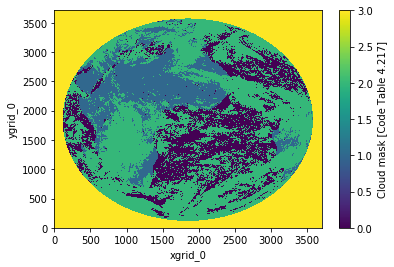

In [10]:
data['CLOUDM_P30_GSV0_I207'].plot()

In [11]:
data.xgrid_0

<xarray.DataArray 'xgrid_0' (xgrid_0: 3712)>
array([   0,    1,    2, ..., 3709, 3710, 3711])
Dimensions without coordinates: xgrid_0

In [16]:
a = np.linspace(start = -67.5, stop = 67.5, endpoint = True, num = 3712)

In [17]:
a

array([-67.5       , -67.46362167, -67.42724333, ...,  67.42724333,
        67.46362167,  67.5       ])

## add coordinates

In [21]:
data['xgrid_0'] = a
data['ygrid_0'] = a
data['time'] = np.datetime64(ts)

In [ ]:
pwd = '/uio/hume/student-u89/hannasv/materTEXT/eumetsat'


In [22]:
data

<xarray.Dataset>
Dimensions:               (xgrid_0: 3712, ygrid_0: 3712)
Coordinates:
  * xgrid_0               (xgrid_0) float64 -67.5 -67.46 -67.43 ... 67.46 67.5
  * ygrid_0               (ygrid_0) float64 -67.5 -67.46 -67.43 ... 67.46 67.5
Data variables:
    CLOUDM_P30_GSV0_I207  (ygrid_0, xgrid_0) float32 ...

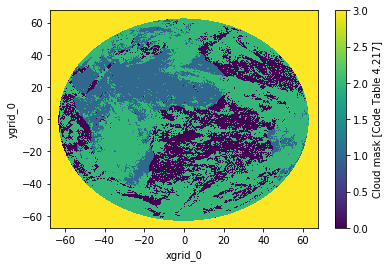

In [24]:
data['CLOUDM_P30_GSV0_I207'].plot()

In [37]:
d_lat=data.sel(ygrid_0 = slice(30,47), xgrid_0 = slice( -42,42, ))

In [35]:
d_lat

<xarray.Dataset>
Dimensions:               (xgrid_0: 2310, ygrid_0: 824)
Coordinates:
  * xgrid_0               (xgrid_0) float64 -42.0 -41.96 -41.93 ... 41.96 42.0
  * ygrid_0               (ygrid_0) float64 30.03 30.07 30.1 ... 59.93 59.97
Data variables:
    CLOUDM_P30_GSV0_I207  (ygrid_0, xgrid_0) float32 ...

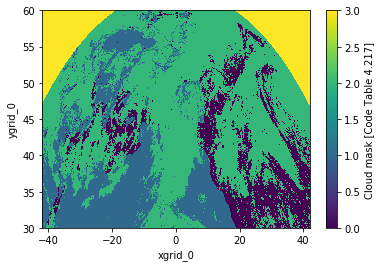

In [36]:
d_lat['CLOUDM_P30_GSV0_I207'].plot()

In [40]:
import cartopy.crs as ccrs

In [44]:
import cartopy as cp
def plot_map(lat = (30,60), lon = (-15,42), path = "maps/",
    title = "MeteoSat vision Europa", filename = "MeteoSat_vision_Europa.png"):
    """
    Plot map defined by lat lon, default Europe.
    Path should be to lagringshotell, don't save png's on git ...
    """
    plt.figure(figsize = (15,15))
    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.add_feature(cp.feature.OCEAN, zorder=0)
    ax.add_feature(cp.feature.LAND, zorder=0, edgecolor='black')
    ax.coastlines(resolution='50m')
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], ccrs.PlateCarree())

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.)

    ax.text(0.03, 0.07, "MeteoSat vision Europa", transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #plt.savefig(path + filename, bbox_inces = "thight")
    plt.show()

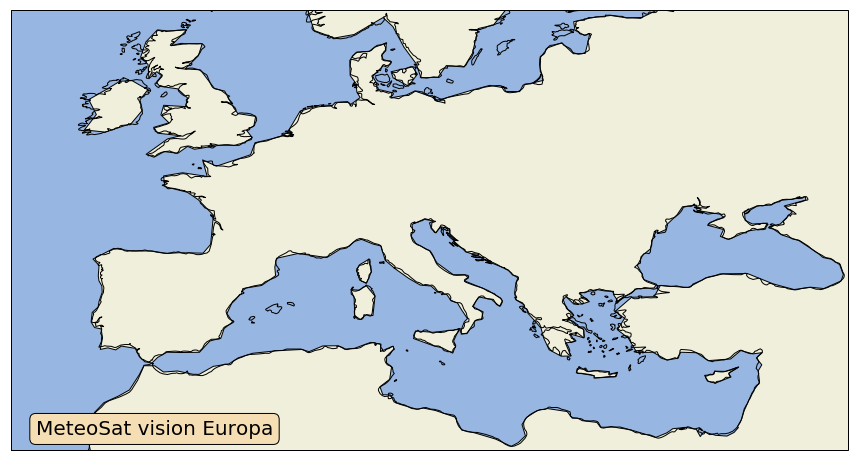

In [45]:
plot_map()

### FIgure out how to crop this and not ge a disk 

In [44]:
d = data['p260537'].values

In [45]:
dim = int(np.sqrt(len(d)))

In [46]:
dim

3712

In [47]:
d = d.reshape((dim, dim ))

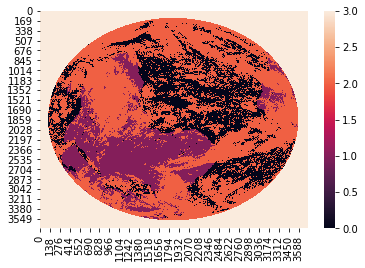

In [48]:
sns.heatmap(d)

In [4]:
path = '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/'

In [5]:
files = glob.glob(path+"*.grb")

In [6]:
files

['/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605000000.000000000Z-20190605001353-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605060000.000000000Z-20190605061402-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605120000.000000000Z-20190605121404-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605180000.000000000Z-20190605181414-1337166.grb']

In [7]:
first_file = files[0]

In [8]:
first_file

'/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605000000.000000000Z-20190605001353-1337166.grb'

In [10]:
data = xr.open_dataset(first_file,engine="cfgrib")

ecCodes provides no latitudes/longitudes for gridType='space_view'


In [11]:
data

<xarray.Dataset>
Dimensions:     (values: 13778944)
Coordinates:
    time        datetime64[ns] ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    p260537     (values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eums
    GRIB_centreDescription:  EUMETSAT Operation Centre
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             EUMETSAT Operation Centre
    history:                 2019-06-06T10:39:02 GRIB to CDM+CF via cfgrib-0....

In [28]:
d = data['p260537'].values

In [29]:
dim = int(np.sqrt(len(d)))

In [30]:
dim

3712

In [31]:
d = d.reshape((dim, dim ))

In [25]:
d = d[::-1]

In [26]:
d = d.reshape((dim, dim ))

In [21]:
import seaborn as sns

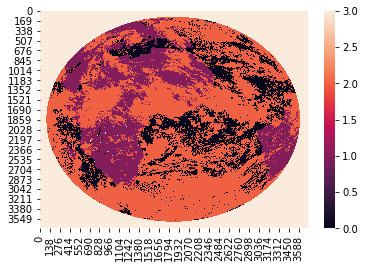

In [27]:
sns.heatmap(d)